# CS 584 Assignment 2 -- MLP and Word Vectors

#### Name: (Matthew Halvorsen)
#### Stevens ID: (10444976)

## Part A: Multi-Layer Perceptron (MLP) (total 30 Points)

## In this assignment, you are required to follow the steps below:
1. Implement the data loading, preprocessing, tokenization, and TF-IDF feature extraction.
2. Implement MLP model, evaluation metrics, and Mini-batch GD with AdaGrad.
3. Implement the MLP with Tensorflow and compare to your implementation.
4. Analysis the results in the Conlusion part.

**Before you start**
- Please read the code very carefully.
- Install these packages (jupyterlab, matplotlib, nltk, numpy, scikit-learn, tensorflow, tensorflow_addons, pandas) using the following command.
```console
pip install -r requirements.txt
```
- It's better to train the Tensorflow model with GPU and CUDA. If they are not available on your local machine, please consider Google CoLab. You can check `CoLab.md` in this assignments.
- You are **NOT** allowed to use other packages unless otherwise specified.
- You are **ONLY** allowed to edit the code between `# Start your code here` and `# End` for each block.

In [ ]:
# you may not run this cell after the first installation
!pip install -r requirements.txt

In [3]:
import tensorflow as tf


tf.config.list_physical_devices('GPU')

[]

## 1. Data Processing (5 points)

* Download the dataset from Canvas
* Load data to text and labels
* Preprocessing
* Tokenization
* Split data
* Feature extraction (TF-IDF)

#### Download NLTK stopwords

In [4]:
import os

import nltk


nltk_path = os.path.join('a2-data', 'nltk')
nltk.download('stopwords', download_dir=nltk_path)
nltk.data.path.append(nltk_path)

[nltk_data] Downloading package stopwords to a2-data/nltk...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import sys


def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    sys.stdout.write(str_ + '\r')
    sys.stdout.flush()

In [6]:
from typing import List, Tuple, Union

import numpy as np

### 1.1 Load data

- Load sentences and labels
- Transform string labels into integers

In [7]:
from typing import List, Tuple
def load_sentence_label(data_path: str) -> Tuple[List[str], List[str]]:
    """ Load sentences and labels from the specified path
    Args:
        data_path: data_path: path to the data file, e.g., 'a1-data/SMSSpamCollection'
        sentences: the raw text list of all sentences
    Returns:
        labels: the label list of all sentences
    """
    sentences, labels = [], []
    # Start your code here (load text and label from files)
    with open(data_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

                # expected format: label \t sentence
            parts = line.split("\t", 1)
            if len(parts) != 2:
                # skip malformed lines (or raise an error if you prefer)
                continue

            label, sentence = parts[0].strip(), parts[1].strip()
            labels.append(label)
            sentences.append(sentence)
    # End
    return sentences, labels

In [8]:
data_path = os.path.join('a2-data', 'books.txt')
sentences, labels = load_sentence_label(data_path)

label_map = {}
for label in sorted(list(set(labels))):
    label_map[label] = len(label_map)
labels = np.array([label_map[label] for label in labels], dtype=int)
sentences = np.array(sentences, dtype=object)

print('Label map:', label_map)
print('Number of sentences and labels:', len(sentences), len(labels))

Label map: {'Arthur Conan Doyle': 0, 'Fyodor Dostoyevsky': 1, 'Jane Austen': 2}
Number of sentences and labels: 19536 19536


#### Split the data into training, validation and test

In [9]:
def train_test_split(sentences: np.ndarray,
                     labels: np.ndarray,
                     test_ratio: float = 0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """ Split the sentences and labels into training and test data by shuffling
    Args:
        sentences: A numpy array containing all sentences
        labels: A number array containing label ids
        test_ratio: A float number to calculate the number of test data

    Returns:
        train_sentences: A numpy array containing all training sentences
        train_labels: A number array containing all training label ids
        test_sentences: A numpy array containing all test sentences
        test_labels: A number array containing all test label ids
    """
    assert 0 < test_ratio < 1
    assert len(sentences) == len(labels)

    train_index, test_index = [], []
    
    n = len(sentences)
    indices = np.arange(n)
    np.random.shuffle(indices)

    test_size = int(n * test_ratio)

    test_index = indices[:test_size]
    train_index = indices[test_size:]

    train_sentences, train_labels = sentences[train_index], labels[train_index]
    test_sentences, test_labels = sentences[test_index], labels[test_index]
    return train_sentences, train_labels, test_sentences, test_labels

In [10]:
np.random.seed(6666)

test_ratio = 0.2
valid_ratio = 0.1
(train_sentences, train_labels,
    test_sentences, test_labels) = train_test_split(sentences, labels, test_ratio)
(train_sentences, train_labels,
    valid_sentences, valid_labels) = train_test_split(train_sentences, train_labels, valid_ratio)

print('Training data length:', len(train_sentences))
print('Validation data length:', len(valid_sentences))
print('Test data length:', len(test_sentences))

Training data length: 14067
Validation data length: 1562
Test data length: 3907


In [11]:
def count_label(labels: np.ndarray, label_map: dict[str, int]) -> dict[str, int]:
    """
    Args:
        labels: The labels of a dataset 
        label_map: The mapping from label to label id
    Returns:
        label_count: The mapping from label to its count
    """
    label_count = {key: 0 for key in label_map.keys()}
    id_to_label = {v: k for k, v in label_map.items()}

    for lab_id in labels:
        label = id_to_label[int(lab_id)]
        label_count[label] += 1
    return label_count

In [12]:
print('Training:', count_label(train_labels, label_map))
print('Validation:', count_label(valid_labels, label_map))
print('Test:', count_label(test_labels, label_map))

Training: {'Arthur Conan Doyle': 1870, 'Fyodor Dostoyevsky': 4234, 'Jane Austen': 7963}
Validation: {'Arthur Conan Doyle': 193, 'Fyodor Dostoyevsky': 464, 'Jane Austen': 905}
Test: {'Arthur Conan Doyle': 475, 'Fyodor Dostoyevsky': 1246, 'Jane Austen': 2186}


#### Dataset statistics
Fill this table with the statistics you just printed (double click this cell to edit)

|                | Arthur Conan Doyle | Fyodor Dostoyevsky | Jane Austen | Total |
|:--------------:|--------------------|--------------------|-------------|-------|
|  **Training**  |        1870        |         4234       |    7963     | 14067 |
| **Validation** |         193        |         464        |     905     |  1562 |
|    **Test**    |         475        |         1246       |     2186    |  3907 |
|    **Total**   |          2538      |         5944       |     11054   | 19536 |


### 1.2 Preprocess
In this section, you need to remove all the unrelated characters, including punctuation, urls, and numbers. Please fill up the functions and test them by running the following cell.

In [13]:
import re


class Preprocessor:
    def __init__(self, punctuation=True, url=True, number=True):
        self.punctuation = punctuation
        self.url = url
        self.number = number

    def apply(self, sentence: str) -> str:
        """ Apply the preprocessing rules to the sentence
        Args:
            sentence: raw sentence
        Returns:
            sentence: clean sentence
        """
        sentence = sentence.lower()
        if self.url:
            sentence = Preprocessor.remove_url(sentence)
        if self.punctuation:
            sentence = Preprocessor.remove_punctuation(sentence)
        if self.number:
            sentence = Preprocessor.remove_number(sentence)
        sentence = re.sub(r'\s+', ' ', sentence)
        return sentence

    @staticmethod
    def remove_punctuation(sentence: str) -> str:
        """ Remove punctuations in sentence with re
        Args:
            sentence: sentence with possible punctuations
        Returns:
            sentence: sentence without punctuations
        """
        sentence = re.sub(r"[^\w\s]", "", sentence)
        return sentence

    @staticmethod
    def remove_url(sentence: str) -> str:
        """ Remove urls in text with re
        Args:
            sentence: sentence with possible urls
        Returns:
            sentence: sentence without urls
        """
        sentence = re.sub(r"http\S+|www\S+", "", sentence)
        return sentence

    @staticmethod
    def remove_number(sentence: str) -> str:
        """ Remove numbers in sentence with re
        Args:
            sentence: sentence with possible numbers
        Returns:
            sentence: sentence without numbers
        """
        sentence = re.sub(r"\d+", "", sentence)
        return sentence

##### Test your implementation by running the following cell.

In [14]:
sentence = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processor = Preprocessor()
clean_sentence = processor.apply(sentence)

print(f'"{sentence}"') 
print('===>')
print(f'"{clean_sentence}"')

"Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"interest rates are trimmed to by the south african central bank but the lack of warning hits the rand and surprises markets"


### 1.3 Tokenization

In [15]:
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk.corpus import stopwords


stopwords_set = set(stopwords.words('english'))
stemmer = PorterStemmer()
print(list(stopwords_set)[:10])

["hadn't", "it'll", 'nor', "she'd", 'between', 'are', 'be', 'each', 'haven', 'he']


In [16]:
def tokenize(sentence: str) -> List[str]:
    """ Tokenize a sentence into tokens (words)
    Args:
        sentence: clean sentence
    Returns:
        tokens
    """
    words = []
    #     Step 1. Split sentence into words
    tokens = word_tokenize(sentence)
    #     Step 2. Extract word stem using the defined stemmer (PorterStemmer) by calling stemmer.stem(word)
    #     Step 3. Remove stop words using the defined stopwords_set
    for word in tokens:
        if word.isalpha():
            stemmed = stemmer.stem(word)
            if stemmed not in stopwords_set:
                words.append(stemmed)
    return words

##### Test your implementation by running the following block.

In [17]:
sentence = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processor = Preprocessor()
clean_sentence = processor.apply(sentence)
tokens = tokenize(clean_sentence)

print(f'"{sentence}"') 
print('===>')
print(f'"{tokens}"')

"Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"['interest', 'rate', 'trim', 'south', 'african', 'central', 'bank', 'lack', 'warn', 'hit', 'rand', 'surpris', 'market']"


### 1.5 Feature Extraction

TF-IDF:
$$\text{TF-IDF}(t, d) = \frac{f_{t, d}}{\sum_{t'}{f_{t', d}}} \times \log{\frac{N}{n_t}}$$

- $t$: A term
- $d$: A document. Here, we regard a sentence as a document
- $f_{t, d}$: Number of term $t$ in $d$
- $N$: Number of document
- $n_t$: Number of document containing $t$

In [18]:
from collections import defaultdict
import math

class TfIdfEncoder:
    def __init__(self):
        self.vocab = defaultdict(int)
        self.token2index = {}
        self.df = defaultdict(int)
        self.num_doc = 0
        self.processor = Preprocessor()

    def fit(self, sentences: Union[List[str], np.ndarray]) -> int:
        """ Using the given texts to store key information in TF-IDF calculation
            In this function, you are required to implement the fitting process.
                1. Construct the vocabulary and store the frequency of tokens (self.vocab).
                2. Construct the document frequency map to tokens (self.df).
                3. Construct the token to index map based on the frequency.
                   The token with a higher frequency has the smaller index
        Args:
            sentences: Raw sentences
        Returns:
            token_num
        """
        self.num_doc = len(sentences)
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == len(sentences) - 1:
                print_line('Fitting TF-IDF encoder:', (i + 1), '/', len(sentences))
            
            clean = self.processor.apply(sentence)
            toks = tokenize(clean)

            # Step 1: update corpus token counts
            for t in toks:
                self.vocab[t] += 1

            # Step 2: update document frequency (count each token once per doc)
            for t in set(toks):
                self.df[t] += 1
            
        print_line('\n')
        
        sorted_tokens = sorted(self.vocab.items(), key=lambda x: x[1], reverse=True)
        self.token2index = {tok: idx for idx, (tok, _) in enumerate(sorted_tokens)}
        
        token_num = len(self.token2index) 
        print('The number of distinct tokens:', token_num)
        return token_num

    def encode(self, sentences: Union[List[str], np.ndarray]) -> np.ndarray:
        """ Encode the sentences into TF-IDF feature vector
            Note: if a token in a sentence does not exist in the fit encoder, we just ignore it.
        Args:
            sentences: Raw sentences
        Returns:
            features: A (n x token_num) matrix, where n is the number of sentences
        """
        n = len(sentences)
        features = np.zeros((n, len(self.token2index)))
        N = self.num_doc if self.num_doc > 0 else 1
        
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == n - 1:
                print_line('Encoding with TF-IDF encoder:', (i + 1), '/', n)

            clean = self.processor.apply(sentence)
            toks = tokenize(clean)

            if not toks:
                continue

            # term frequency in THIS document
            tf_counts = defaultdict(int)
            for t in toks:
                if t in self.token2index:   # ignore unseen tokens
                    tf_counts[t] += 1

            doc_len = sum(tf_counts.values())
            if doc_len == 0:
                continue

            for t, c in tf_counts.items():
                j = self.token2index[t]

                # TF (normalized)
                tf = c / doc_len

                # IDF (smoothed)
                df_t = self.df.get(t, 0)
                idf = math.log((1 + N) / (1 + df_t)) + 1.0

                features[i, j] = tf * idf

        print_line('\n')
        return features

##### Test your implementation by running the following cell.

In [19]:
encoder = TfIdfEncoder()
encoder.fit(train_sentences[:100])
features = encoder.encode(train_sentences[:10])

print(features[:5])

Fitting TF-IDF encoder: 100 / 100
The number of distinct tokens: 1459
Encoding with TF-IDF encoder: 10 / 10
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.23192837 ... 0.         0.         0.        ]
 [0.         0.13428918 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.03174377 0.09809405 0.         ... 0.         0.         0.        ]]


#### Encode training, validation, and test dataset

In [20]:
num_class = 3

encoder = TfIdfEncoder()
vocab_size = encoder.fit(train_sentences)

x_train = encoder.encode(train_sentences)
x_valid = encoder.encode(valid_sentences)
x_test = encoder.encode(test_sentences)

y_train = np.zeros((len(train_labels), num_class))
y_valid = np.zeros((len(valid_labels), num_class))
y_test = np.zeros((len(test_labels), num_class))
y_train[np.arange(len(train_labels)), train_labels] = 1
y_valid[np.arange(len(valid_labels)), valid_labels] = 1
y_test[np.arange(len(test_labels)), test_labels] = 1

print('The size of training set:', x_train.shape, y_train.shape)
print('The size of validation set:', x_valid.shape, y_valid.shape)
print('The size of test set:', x_test.shape, y_test.shape)

Fitting TF-IDF encoder: 14067 / 14067
The number of distinct tokens: 16212
Encoding with TF-IDF encoder: 14067 / 14067
Encoding with TF-IDF encoder: 1562 / 1562
Encoding with TF-IDF encoder: 3907 / 3907
The size of training set: (14067, 16212) (14067, 3)
The size of validation set: (1562, 16212) (1562, 3)
The size of test set: (3907, 16212) (3907, 3)


## 2. MLP
In this section, you are required to implement a two-layer MLP model (input -> hidden layer -> output layer) with $L_2$ regularization from scratch. 

The objective function of LR for multi-class classification:

$$J = L(\mathbf{x}, \mathbf{y} \mid \mathbf{w}, \mathbf{b}) = -\frac{1}{n}\sum_{i=1}^{N}\sum_{k=1}^{K}y_{ik}log\frac{e^{f_k}}{\sum_{c=1}^{K}e^{f_c}} + \lambda \sum_{j=1}^{d}w_{kj}^2$$

- $z_1 = w_1x$
- $h_1 = activation(z_1)$
- $z_2 = w_2 h_1$
- $\hat{y} = softmax(z_2)$

- $n$: Number of samples
- $d$: Dimension of $\mathbf{w}$
- Here, you can use `sigmoid` as the activation function for the hidden layer.

### 2.1 MLP Model (5 Points)

In [21]:
def softmax(x: np.ndarray, axis: int = -1) -> np.ndarray:
    """ The softmax activation function
    Args:
        x: Input matrix or vector
        axis: The dimension of x that needs to run softmax, default -1, i.e., the last dimension
    Returns:
        output: Softmax value of the specified dimension in x
    """
    
    x_max = np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x - x_max)
    x = exp_x / np.sum(exp_x, axis=axis, keepdims=True)
    
    return x


def sigmoid(x: np.ndarray) -> np.ndarray:
    """ The sigmoid activation function
    Args:
        x: Input matrix or vector
    Returns:
        output: Sigmoid value of each entry in x
    """
    x = 1 / (1 + np.exp(-x))
    
    return x

In [22]:
class MLP:
    def __init__(self, feature_dim: int, hidden_dim: int, num_class: int, lambda_: float):
        """ MLP Model
        Args:
            feature_dim: feature dimension
            hidden_dim: hidden units
            num_class: number of class
            lambda_: lambda in L2 regularizer
        """
        self.w1 = np.random.randn(feature_dim, hidden_dim) * np.sqrt(2.0 / feature_dim)
        self.b1 = np.zeros((hidden_dim,), dtype=float)
        self.w2 = np.random.randn(hidden_dim, num_class) * np.sqrt(1.0 / hidden_dim)
        self.b2 = np.zeros((num_class,), dtype=float)

        self.lambda_ = lambda_
        self.eps = 1e-9

    def forward(self, x: np.ndarray, return_hiddens: bool = False) -> np.ndarray:
        """ Forward process of logistic regression
            Calculate y_hat using x
        Args:
            x: Input data
            return_hiddens: If true the function will return h1 for gradient calculation
        Returns:
            y_hat: Output
            h1: Hidden output, used for gradient calculation. Returned if return_hiddens is set to True
        """
        y_hat = 0
        h1 = 0, 0
        w1, b1, w2, b2 = self.w1, self.b1, self.w2, self.b2
        
        z1 = x @ w1 + b1
        a1 = np.maximum(0.0, z1)
        z2 = a1 @ w2 + b2
        y_hat = softmax(z2, axis=-1)
        h1 = (z1, a1)
        
        if return_hiddens:
            return y_hat, h1
        else:
            return y_hat

    def backward(self,
                 x: np.ndarray,
                 y_hat: np.ndarray,
                 y: np.ndarray,
                 h1: np.array) -> Tuple[np.ndarray, Union[float, np.ndarray], np.ndarray, Union[float, np.ndarray]]:
        """ Backward process of logistic regression
            Calculate the gradient of w and b
        Args:
            x: Input data
            y_hat: Output of forward
            y: Ground-truth
            h1: Hidden output of the hidden layer
        Returns:
            dw1: Gradient of w1
            db1: Gradient of b1
            dw2: Gradient of w2
            db2: Gradient of b2
        """
        w1, w2 = self.w1, self.w2
        dw1, db1, dw2, db2 = 0.0, 0.0, 0.0, 0.0
        n = len(x)
        
        z1, a1 = h1
        
        dz2 = (y_hat - y) / n               # (n, num_class)

        dw2 = a1.T @ dz2                    # (hidden, num_class)
        db2 = np.sum(dz2, axis=0)           # (num_class,)

        da1 = dz2 @ w2.T                    # (n, hidden)
        dz1 = da1 * (z1 > 0).astype(float)  # ReLU grad

        dw1 = x.T @ dz1                     # (feature_dim, hidden)
        db1 = np.sum(dz1, axis=0)           # (hidden,)

        # L2 regularization (biases typically not regularized)
        dw2 += self.lambda_ * w2
        dw1 += self.lambda_ * w1
        
        return dw1, db1, dw2, db2

    def categorical_cross_entropy_loss(self,
                                       y_hat: np.ndarray,
                                       y: np.ndarray) -> Union[float, np.ndarray]:
        """ Calculate the binary cross-entropy loss
        Args:
            y_hat: Output of forward
            y: Ground-truth
        Returns:
            loss: BCE loss
        """
        y_hat = np.clip(y_hat, a_min=self.eps, a_max=1 - self.eps)
        loss = 0
        
        data_loss = -np.sum(y * np.log(y_hat)) / len(y)

        reg_loss = 0.5 * self.lambda_ * (np.sum(self.w1 ** 2) + np.sum(self.w2 ** 2))
        loss = data_loss + reg_loss
        
        return loss

    def gradient_descent(self, dw1: np.ndarray, db1: Union[np.ndarray, float], dw2: np.ndarray, db2: Union[np.ndarray, float], lr: float):
        self.w1 -= lr * dw1
        self.b1 -= lr * db1
        self.w2 -= lr * dw2
        self.b2 -= lr * db2

    def predict(self, y_hat: np.ndarray) -> np.ndarray:
        """ Predict the label using the output y_hat
        Args:
            y_hat: Model output
        Returns:
            pred: Prediction
        """
        pred = np.zeros_like(y_hat)
        index = np.argmax(y_hat, axis=-1)
        pred[np.arange(len(y_hat)), index] = 1
        return pred

### 2.2 Evaluation Metrics

Accuracy, Precision, Recall, F1

In [23]:
from sklearn.metrics import precision_recall_fscore_support


def get_metrics(y_pred: np.ndarray, y_true: np.ndarray) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray]:
    """ Calculate the accuracy, precision, recall, and f1 score.
        You are allowed to use precision_recall_fscore_support from scikit-learn. Please set average to 'micro'
    Args:
        y_pred: Prediction
        y_true: Ground-truth
    Returns:
        accuracy: float number. The accuracy for the whole dataset
        precision, recall, f1: np.ndarray (num_class, ). The precision, recall, f1 for each class
    """
    assert y_pred.shape == y_true.shape
    accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
    
    pred_labels = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_true, axis=1)

    accuracy = np.mean(pred_labels == true_labels)

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels,
        pred_labels,
        average="micro"
    )
    
    return accuracy, precision, recall, f1

### 2.3 AdaGrad (5 points)

$$ \mathbf{G}^{(t + 1)} \leftarrow \mathbf{G}^{(t)} + \boldsymbol{g}^{(t + 1)} \cdot \boldsymbol{g}^{(t + 1)} $$
$$ \mathbf{w}^{(t + 1)} \leftarrow \mathbf{w}^{(t)} - \frac{\eta}{\sqrt{\mathbf{G}^{(t + 1)} + \epsilon}}\boldsymbol{g}^{(t + 1)} = \mathbf{w}^{(t)} - \eta\frac{\boldsymbol{g}^{(t + 1)}}{\sqrt{\mathbf{G}^{(t + 1)} + \epsilon}} $$

In [24]:
class AdaGrad:
    def __init__(self, init_lr, model):
        self.init_lr = init_lr
        self.model = model
        
        self.accumulative_dw1 = 0
        self.accumulative_db1 = 0
        self.accumulative_dw2 = 0
        self.accumulative_db2 = 0
        self.eps = 1e-9
        
    def update(self, dw1: np.ndarray, db1: Union[np.ndarray, float], dw2: np.ndarray, db2: Union[np.ndarray, float]):
        """ 1. Use the gradient in the current step to update the accumulative gradient of each parameter.
            2. Calculate the new gradient with the accumulative gradient
            3. Use the init learning rate the new gradient to update the parameter with model.gradient_descent()
        
        Do not return anything
        """
        # Start your code here
        # Step 1
        self.accumulative_dw1 = self.accumulative_dw1 + dw1 * dw1
        self.accumulative_db1 = self.accumulative_db1 + db1 * db1
        self.accumulative_dw2 = self.accumulative_dw2 + dw2 * dw2
        self.accumulative_db2 = self.accumulative_db2 + db2 * db2
        # Step 2
        adj_dw1 = dw1 / (np.sqrt(self.accumulative_dw1) + self.eps)
        adj_db1 = db1 / (np.sqrt(self.accumulative_db1) + self.eps)
        adj_dw2 = dw2 / (np.sqrt(self.accumulative_dw2) + self.eps)
        adj_db2 = db2 / (np.sqrt(self.accumulative_db2) + self.eps)
        # Step 3
        self.model.gradient_descent(adj_dw1, adj_db1, adj_dw2, adj_db2, self.init_lr)
        # End

        

### 2.4 Mini-batch Gradient Descent (5 Points)

In [25]:
from collections import OrderedDict


def train_mbgd(model: 'MLP',
               x_train: np.ndarray,
               y_train: np.ndarray,
               x_valid: np.ndarray,
               y_valid: np.ndarray,
               lr: float,
               num_epoch: int,
               batch_size: int,
               print_every: int = 10) -> Tuple[dict[str, List], dict[str, List]]:
    """ Training with Gradient Descent
    Args:
        model: The logistic regression model
        x_train: Training feature, (n x d) matrix
        y_train: Training label, (n, ) vector
        x_valid: Validation feature, (n x d) matrix
        y_valid: Validation label, (n, ) vector
        lr: Learning rate
        num_epoch: Number of training epochs
        batch_size: Number of training samples in a batch
        print_every: Print log every {print_every} epochs
    Returns:
        train_history: Log of training information. The format of training history is
                       { 'loss': [] }
                       It records the average loss of each epoch.
        valid_history: Log of validation information. The format of training and validation history is
                       {
                           'loss': [],
                           'accuracy': [],
                           'precision': [],
                           'recall': [],
                           'f1': []
                       }
    """
    train_history = OrderedDict({'loss': []})
    valid_history = OrderedDict({
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    })

    def format_output(epoch, num_epoch, train_history, valid_history):
        epoch_log = f'Epoch {epoch + 1} / {num_epoch}'
        train_log = ' - '.join([f'train_{key}: {val[-1]:.4f}' for key, val in train_history.items()])
        valid_log = ' - '.join([f'valid_{key}: {val[-1]:.4f}' for key, val in valid_history.items()])
        log = f'{epoch_log}: {train_log} - {valid_log}'
        return log

    # IMPORTANT: YOU SHOULD USE THIS OPTIMIZER TO UPDATE THE MODEL
    optimizer = AdaGrad(init_lr=lr, model=model)

    train_num_samples = len(x_train)
    n_batch = train_num_samples // batch_size
    for epoch in range(num_epoch):
        epoch_loss = 0.0
        perm = np.random.permutation(train_num_samples)
        x_shuf = x_train[perm]
        y_shuf = y_train[perm]

        for b in range(n_batch):
            start = b * batch_size
            end = start + batch_size
            xb = x_shuf[start:end]
            yb = y_shuf[start:end]

            # Step 1. Model forward
            y_hat, h1 = model.forward(xb, return_hiddens=True)

            # Step 2. Calculate loss
            batch_loss = model.categorical_cross_entropy_loss(y_hat, yb)
            epoch_loss += batch_loss * len(xb)  # sum over samples

            # Step 3. Model backward
            dw1, db1, dw2, db2 = model.backward(xb, y_hat, yb, h1)

            # Step 4. Optimization with Adagrad
            optimizer.update(dw1, db1, dw2, db2)

        valid_loss = 0.
        accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
        
        y_hat_valid = model.forward(x_valid, return_hiddens=False)
        y_pred_valid = model.predict(y_hat_valid)

        # Step 2. Calculate loss
        valid_loss = model.categorical_cross_entropy_loss(y_hat_valid, y_valid)

        # Step 3. Calculate metrics
        accuracy, precision, recall, f1 = get_metrics(y_pred_valid, y_valid)

        train_history['loss'].append(epoch_loss / train_num_samples)
        for vals, val in zip(valid_history.values(), [valid_loss, accuracy, precision, recall, f1]):
            vals.append(val)
        log = format_output(epoch, num_epoch, train_history, valid_history)
        if epoch % print_every == 0 or epoch == num_epoch - 1:
            print(log)
        else:
            print_line(log)

    return train_history, valid_history

Run Mini-batch Gradient Descent

In [26]:
np.random.seed(6666)

hidden_dim = 128
num_epoch = 100
lr = 1e-2
batch_size = 128
lambda_ = 1e-8
print_every = 10

model_mbgd = MLP(feature_dim=vocab_size, hidden_dim=hidden_dim, num_class=num_class, lambda_=lambda_)
mbgd_train_history, mbgd_valid_history = train_mbgd(model_mbgd, x_train, y_train, x_valid, y_valid, lr, num_epoch, batch_size, print_every)

Epoch 1 / 100: train_loss: 0.4442 - valid_loss: 0.2846 - valid_accuracy: 0.9161 - valid_precision: 0.9161 - valid_recall: 0.9161 - valid_f1: 0.9161
Epoch 11 / 100: train_loss: 0.0592 - valid_loss: 0.2544 - valid_accuracy: 0.9270 - valid_precision: 0.9270 - valid_recall: 0.9270 - valid_f1: 0.9270
Epoch 21 / 100: train_loss: 0.0417 - valid_loss: 0.2863 - valid_accuracy: 0.9251 - valid_precision: 0.9251 - valid_recall: 0.9251 - valid_f1: 0.9251
Epoch 31 / 100: train_loss: 0.0346 - valid_loss: 0.3077 - valid_accuracy: 0.9257 - valid_precision: 0.9257 - valid_recall: 0.9257 - valid_f1: 0.9257
Epoch 41 / 100: train_loss: 0.0310 - valid_loss: 0.3243 - valid_accuracy: 0.9238 - valid_precision: 0.9238 - valid_recall: 0.9238 - valid_f1: 0.9238
Epoch 51 / 100: train_loss: 0.0287 - valid_loss: 0.3401 - valid_accuracy: 0.9238 - valid_precision: 0.9238 - valid_recall: 0.9238 - valid_f1: 0.9238
Epoch 61 / 100: train_loss: 0.0272 - valid_loss: 0.3524 - valid_accuracy: 0.9238 - valid_precision: 0.9238 

### 2.5 MLP using Tensorflow (5 Points)

In [29]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras.activations import sigmoid


class MLPTF(Model):
    def __init__(self, feature_dim: int, hidden_dim: int, num_class: int, lambda_: float):
        """ MLP Model using tensorflow.keras
        Args:
            feature_dim: feature dimension
            hidden_dim: hidden units
            num_class: number of class
            lambda_: lambda in L2 regularizer
        """
        super().__init__()
        self.dense1 = Dense(
            hidden_dim,
            activation="relu",
            kernel_regularizer=regularizers.l2(lambda_),
            input_shape=(feature_dim,)
        )
        self.dense2 = Dense(
            num_class,
            activation=None,  # logits
            kernel_regularizer=regularizers.l2(lambda_)
        )
        self.softmax = Softmax(axis=-1)
        
    def call(self, x):
        """ Forward function of tf. It should be named 'call'
        
        Args:
            x: (n x feature_dim) tensor
        Returns:
            y_hat: (n x num_class) tensor
        """
        h1 = self.dense1(x)
        logits = self.dense2(h1)
        y_hat = self.softmax(logits)
        return y_hat

In [30]:
import tensorflow_addons as tfa
np.random.seed(6666)
tf.random.set_seed(6666)


hidden_dim = 128
num_epoch = 100
lr = 1e-1
batch_size = 128
lambda_ = 1e-8

model_tf = MLPTF(feature_dim=vocab_size, hidden_dim=hidden_dim, num_class=num_class, lambda_=lambda_)
model_tf.build(input_shape=(None, vocab_size))
model_tf.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(num_classes=num_class, average='micro')])
model_tf.summary()

Model: "mlptf_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             multiple                  2075264   
                                                                 
 dense_3 (Dense)             multiple                  387       
                                                                 
 softmax_1 (Softmax)         multiple                  0         
                                                                 
Total params: 2075651 (7.92 MB)
Trainable params: 2075651 (7.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
tf_history = model_tf.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), batch_size=batch_size, epochs=num_epoch)

Epoch 1/100
110/110 [==============================] - 1s 7ms/step - loss: 0.8742 - categorical_accuracy: 0.6008 - f1_score: 0.6009 - val_loss: 0.7450 - val_categorical_accuracy: 0.6940 - val_f1_score: 0.6940
Epoch 2/100
110/110 [==============================] - 1s 6ms/step - loss: 0.6266 - categorical_accuracy: 0.7742 - f1_score: 0.7742 - val_loss: 0.5339 - val_categorical_accuracy: 0.7990 - val_f1_score: 0.7990
Epoch 3/100
110/110 [==============================] - 1s 6ms/step - loss: 0.4546 - categorical_accuracy: 0.8428 - f1_score: 0.8428 - val_loss: 0.4310 - val_categorical_accuracy: 0.8547 - val_f1_score: 0.8547
Epoch 4/100
110/110 [==============================] - 1s 6ms/step - loss: 0.3545 - categorical_accuracy: 0.8817 - f1_score: 0.8817 - val_loss: 0.3665 - val_categorical_accuracy: 0.8745 - val_f1_score: 0.8745
Epoch 5/100
110/110 [==============================] - 1s 6ms/step - loss: 0.2898 - categorical_accuracy: 0.9107 - f1_score: 0.9107 - val_loss: 0.3287 - val_categor

#### Evaluation with Tensorflow
You are required to report the loss, accuracy, precision, recall, and f1 on test set and plot the the curve of them for both SGD and Mini-batch GD on train and validation set

In [32]:
# Calculate the metrics for test set and fill in the table below
y_hat = model_mbgd.forward(x_test)
y_pred = model_mbgd.predict(y_hat)
print('Mini-batch GD:', get_metrics(y_pred, y_test))
model_tf.evaluate(x=x_test, y=y_test)

Mini-batch GD: (0.9111850524699258, 0.9111850524699258, 0.9111850524699258, 0.9111850524699258)
123/123 [==============================] - 0s 2ms/step - loss: 0.4718 - categorical_accuracy: 0.9122 - f1_score: 0.9122


[0.4718446433544159, 0.9122088551521301, 0.9122088551521301]

#### Evaluation Metrics on Test set
Fill this table with the result you just printed (double click this cell to edit)
|     Optimizer                     | Accuracy    | F1 Score    |
|:---------------------------------:|-------------|-------------|
|      **Your Implementation**      |    0.911    |    0.911    |
| **Tensorflow**                    |    0.912    |    0.912    |

##### Please run the following cell to plot the training loss curve for Your implementation and Tensorflow

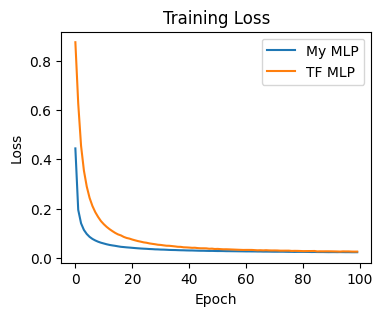

In [33]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(4, 3))
plt.plot(mbgd_train_history['loss'], label='My MLP')
plt.plot(tf_history.history['loss'], label='TF MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

##### Please run the following cell to plot the validation metrics curve for SGD and Mini-batch GD

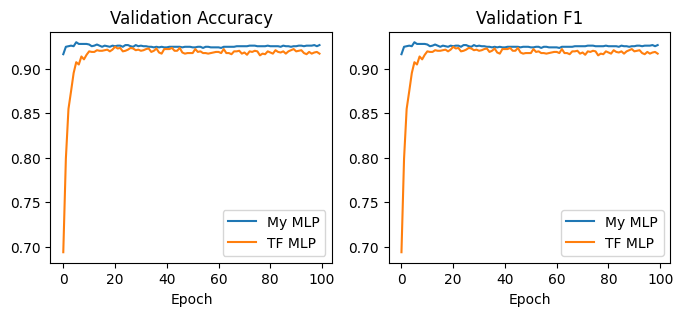

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
ax = axes[0]
ax.plot(mbgd_valid_history['accuracy'], label='My MLP')
ax.plot(tf_history.history['val_categorical_accuracy'], label='TF MLP')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_title('Validation Accuracy')

ax = axes[1]
ax.plot(mbgd_valid_history['f1'], label='My MLP')
ax.plot(tf_history.history['val_f1_score'], label='TF MLP')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_title('Validation F1')
plt.show()

# 3. Conclusion (5 Points)

Provide an analysis for all the results

Answer: 
The results from both models were very similar. The first thing to point out is how the implementation of the tensorflow module is very compact and does not require a lot of additional code to run. My implementation requires a lot more code in order to run effectively which leads to more potential errors such as an exploding gradient if not handled properly. For the actual metrics, there were very minor differences between the two models. The accuracy for the model built from scratch was .911 while the tensorflow implementation was .912, this trend followed for f1 as my model gave a value of 0.911 and tensorflow returned a value of 0.912. This is indicative of the model being essentially identical when it comes to performance. One major difference between the two models was the epoch it took to converge. This can be seen in the graph for training loss vs epoch. My model converged ti a lower training loss from the beginning at roughly 0.44 while the tensorflow model loss started at 0.87. This could be caused for a variety of reasons like how the models inital weights were initialized or regularization method. Roughly, somewhere between 40 and 60 epochs my model and tensorflow model converged to the same point. This same trend is shown in the validation accuracy vs epoch graph and the validation vs epoch graph, my model reached a high validation accuracy and f1 score very quickly while the tensorflow model had a more gradual convergence. One clear difference between the two models was the learning rate which was set to .01 for my model while the tensorflow model used a learning rate of 0.1. This could have contributed to the tensorflow model having more instability and a higher loss during the intial epochs as it could cause noisier updates to the weights causing for more updates to be needed to reach convergence. Overall these results are promising considering the dataset is very unbalanced and small. It would be interesting to see how many of the false positive or negatives are coming from the smaller classes in the dataset.